<a href="https://colab.research.google.com/github/alexlapshov89/ALapshov_coding/blob/main/ml_7_part2_hw_optimization_of_hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-7. Оптимизация гиперпараметров модели. Практика

In [47]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

#import optuna

%matplotlib inline
plt.style.use('seaborn')

ModuleNotFoundError: ignored

## 1. Введение

Цели:
* Создать модели "логистическая регрессия" и "случайный лес";
* Провести оптимизацию каждой модели с помощью четырех методов GridSearchCV, RandomSearchCV, Hyperopt, Optuna;
* Сравнить метрики, полученные каждым из методов. 


## 2. Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#ЕСЛИ РАБОТАЕМ В IDE
#data = pd.read_csv('https://drive.google.com/file/d/1RidLNVOGpOGhyADMs7H2N9SInJhePEiH/view?usp=sharing')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skillfactory/ML-7 Оптимизация гиперпараметров модели/data/_train_sem09 (1).csv')
print(data.shape)
data.head()

(3751, 1777)


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


По условию задачи предобработка данных не требуется.

In [4]:
data.isnull().sum().unique() # проверка отсутствия пропусков

array([0])

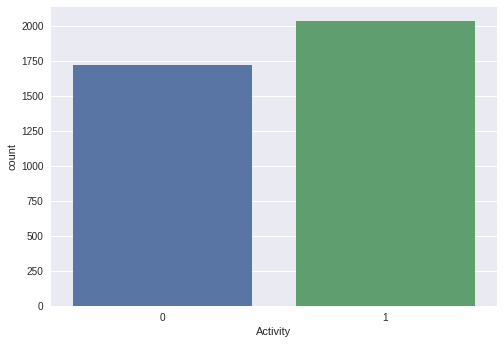

In [5]:
sns.countplot(data=data, x='Activity') # cмотрим на сбалансированность классов

In [6]:
# Проверка отсутствия признаков типа "object"
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

[]

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [7]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

## 3. Создание моделей и расчет метрики без оптимизации гиперпараметров

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [9]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42,max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


In [10]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 1.00
f1_score на тестовом наборе: 0.81


## 4. Оптимизация гиперпараметров моделей с помощью GridSearchCV

In [11]:
# Оптимизация модели логистической регрессии
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 8.83 s, sys: 990 ms, total: 9.82 s
Wall time: 8min 10s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs'}


Значение метрики модели логистической регрессии не изменилось.

In [13]:
# Оптимизация модели случайного леса
param_grid = {'n_estimators': list(range(100, 200, 30)) ,
                      'min_samples_leaf': [5, 7],
                      'max_depth': [10, 15, 20, 25]},
            
grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 3.69 s, sys: 197 ms, total: 3.88 s
Wall time: 3min 32s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 7, 'n_estimators': 130}


Значение метрики для модели случайного леса увеличилось до 0.82 (на 0.01).

## 5. Оптимизация гиперпараметров моделей с помощью RandomSearchCV

In [16]:
# Оптимизация модели логистической регрессии
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: user 7.44 s, sys: 906 ms, total: 8.35 s
Wall time: 11min 44s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.34}


Значение метрики не изменилось.

In [17]:
# Оптимизация модели случайного леса
param_distributions = {'n_estimators': list(range(100, 200, 30)) ,
                      'min_samples_leaf': [5, 7],
                      'max_depth': [10, 15, 20, 25]},
            
random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: user 2.27 s, sys: 76 ms, total: 2.34 s
Wall time: 1min 1s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 7, 'max_depth': 20}


Значение метрики увеличилось до 0.82 (на 0.01). Время оптимизации существенно меньше по сравнению с методом GridSearchCV.

## 6. Оптимизация гиперпараметров моделей с помощью HyperOpt

Оптимизация параметров модели логистической регрессии

In [26]:
# зафксируем random_state
random_state = 42

In [34]:
# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver' : hp.choice('solver', ['lbfgs', 'saga']),
       'C'      : hp.uniform('C',0.01, 1)
      }

In [44]:
def hyperopt_lg_reg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty' : params['penalty'], 
              'solver'  : params['solver'],
              'C'       : params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params,random_state=random_state,max_iter=1000)
    
    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [45]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lg_reg, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=5, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



 20%|██        | 1/5 [05:48<23:13, 348.48s/it, best loss: -0.7546660089494158]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



 60%|██████    | 3/5 [06:45<03:16, 98.20s/it, best loss: -0.7725500552483722] 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



100%|██████████| 5/5 [09:13<00:00, 110.73s/it, best loss: -0.7808818198236848]
Наилучшие значения гиперпараметров {'C': 0.18015284578259508, 'penalty': 0, 'solver': 1}
CPU times: user 2min 15s, sys: 6.27 s, total: 2min 21s
Wall time: 9min 13s


In [46]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(penalty='l2',
                                        solver='saga',
                                        C=float(best['C']),
                                        random_state=random_state,max_iter=1000)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.86
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


Значение метрики не изменилось.

Оптимизация параметров модели случайного леса

In [64]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 10, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [65]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [66]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [02:22<00:00,  7.12s/it, best loss: -0.8081972440473727]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
CPU times: user 1.83 s, sys: 599 ms, total: 2.42 s
Wall time: 2min 22s


In [24]:
# дополнительные итерации оптимизации
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=30, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 10/10 [01:21<00:00,  8.18s/it, best loss: -0.8109663704182667]
Наилучшие значения гиперпараметров {'max_depth': 26.0, 'min_samples_leaf': 2.0, 'n_estimators': 132.0}


In [67]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


Значение метрики увеличилось до 0.82 (на 0.01).

## 7. Оптимизация гиперпараметров моделей с помощью Optuna

In [48]:
# Устанавливаем библиотеку
!pip install optuna
# или
#!conda install -c conda-forge optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 8.5 MB/s 
     |████████████████████████████████| 209 kB 54.3 MB/s 
     |████████████████████████████████| 81 kB 10.4 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 147 kB 63.1 MB/s 
     |████████████████████████████████| 112 kB 67.9 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=83868e1b2f0fa4ead125769ee3be72cf8175c5c112e409c53527f282d439d7ec
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [49]:
# импорт
import optuna

Оптимизация модели логистической регрессии

In [58]:
def optuna_lg_reg(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'] )
  C = trial.suggest_float('C', 0.05, 1, step=0.05)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=random_state)
  # обучаем модель
  #model.fit(X_train_scaled, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return score
  

In [59]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lg_reg, n_trials=20)

[I 2022-09-17 11:58:55,204] A new study created in memory with name: LogisticRegression
[I 2022-09-17 11:58:59,183] Trial 0 finished with value: 0.7475536741581407 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 1.0}. Best is trial 0 with value: 0.7475536741581407.
[I 2022-09-17 11:59:25,087] Trial 1 finished with value: 0.7782245707805978 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.55}. Best is trial 1 with value: 0.7782245707805978.
[I 2022-09-17 11:59:28,428] Trial 2 finished with value: 0.7718082028399963 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.8}. Best is trial 1 with value: 0.7782245707805978.
[I 2022-09-17 11:59:56,155] Trial 3 finished with value: 0.7742392087080294 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.9500000000000001}. Best is trial 1 with value: 0.7782245707805978.
[I 2022-09-17 12:00:21,679] Trial 4 finished with value: 0.7751067514546518 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.750000000

CPU times: user 3.19 s, sys: 739 ms, total: 3.93 s
Wall time: 6min 48s


In [60]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.80


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Значение метрики увеличилось на 0.02

Оптимизация модели случайного леса

In [61]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  #model.fit(X_train_scaled, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  return score
  
  

In [62]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-09-17 12:09:54,005] A new study created in memory with name: RandomForestClassifier
[I 2022-09-17 12:10:03,532] Trial 0 finished with value: 0.8075291823518695 and parameters: {'n_estimators': 159, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8075291823518695.
[I 2022-09-17 12:10:11,075] Trial 1 finished with value: 0.7935241118169724 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8075291823518695.
[I 2022-09-17 12:10:18,789] Trial 2 finished with value: 0.8015538236065755 and parameters: {'n_estimators': 139, 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8075291823518695.
[I 2022-09-17 12:10:27,372] Trial 3 finished with value: 0.8020954289606772 and parameters: {'n_estimators': 102, 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8075291823518695.
[I 2022-09-17 12:10:36,099] Trial 4 finished with value: 0.7983176524074121 and parameters: {'n_

CPU times: user 1.91 s, sys: 541 ms, total: 2.45 s
Wall time: 2min 28s


In [63]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


Значение метрики не изменилось.

## Выводы

В ходе работы по оптимизации гиперпараметров моделей удалось улучшить метрики (f1-score) для обоих моделей: для логистической регрессии улучшение с 0.78 до 0.80 было получено с помощью библиотеки Optuna; для модели случайного леса улучшение метрики с 0.81 до 0.82 было получено с использованием всех методов, кроме Optuna. Отмечаю, что предсказательная способность модели случайный лес изначально оказалась выше. При этом для оптимизации использовались пространства гиперпараметров, взятые из практических заданий к курсу. Не исключено, что использование других значений гиперпараметров может дополнительно улучшить исследуемые метрики.